In [1]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=74a1a14dee44f82cecb02fb4d8fe16f72b8e023c3a981d6f24dc33e4a3350279
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/alpaca-instructions-word-level-classification/train.csv')
df['instruction length'] = df['instruction'].str.len()
df['text length'] = df['text'].str.len()

terms = {
    'c++': ['c++'],
    'javascript': ['js', 'javascript'],
    'python': ['python'],
    'react': ['react'],
    'ruby': ['ruby'],
    'sql': ['sql'],
}

for key, values in terms.items():
    df[key] = df['instruction'].apply(func=lambda x: any([value in x.lower() for value in values]))
    print('{} count: {}'.format(key, df[key].sum()))
df['other'] = ~df[list(terms.keys())].any(axis=1)
print('other count: {}'.format(df['other'].sum()))
df = df[df['react']].drop(columns=list(terms.keys())) # let's just look at our React cluster

df.head()

c++ count: 3510
javascript count: 13172
python count: 17999
react count: 3567
ruby count: 1027
sql count: 9170
other count: 74461


,input,instruction,text,output,instruction length,text length,other
18,Not applicable,Create a React application to input two number...,Below is an instruction that describes a task....,"import React, { useState } from ""react"";\n\nco...",89,1089,False
35,Not applicable,Develop a React component to render a list of ...,Below is an instruction that describes a task....,import React from 'react';\n\nconst CommentsLi...,102,645,False
79,"Data Points: [{x: 1, y: 10}, {x: 2, y: 20}, {x...",Create a React component that displays given d...,Below is an instruction that describes a task....,"import React, { Component } from 'react';\nimp...",79,1321,False
105,Not applicable,Design a React component for displaying tabs.,Below is an instruction that describes a task....,"import React, { useState } from 'react';\n\nco...",45,1101,False
205,Not applicable,Create a React application for a simple to-do ...,Below is an instruction that describes a task....,//importing all the necessary components \nimp...,139,2247,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3567 entries, 18 to 121949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   input               3303 non-null   object
 1   instruction         3567 non-null   object
 2   text                3567 non-null   object
 3   output              3567 non-null   object
 4   instruction length  3567 non-null   int64 
 5   text length         3567 non-null   int64 
 6   other               3567 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 198.6+ KB


In [4]:
df.nunique()

input                  854
instruction           3565
text                  3567
output                3565
instruction length     248
text length           1453
other                    1
dtype: int64

In [5]:
from plotly.express import histogram
for column in [item for item in df.columns if item.endswith('length')]:
    histogram(data_frame=df, x=column, log_y=True).show()

In [6]:
from plotly.express import scatter
scatter(data_frame=df, x='text length', y='instruction length', log_x=True, log_y=True)

(-0.5, 1199.5, 1199.5, -0.5)

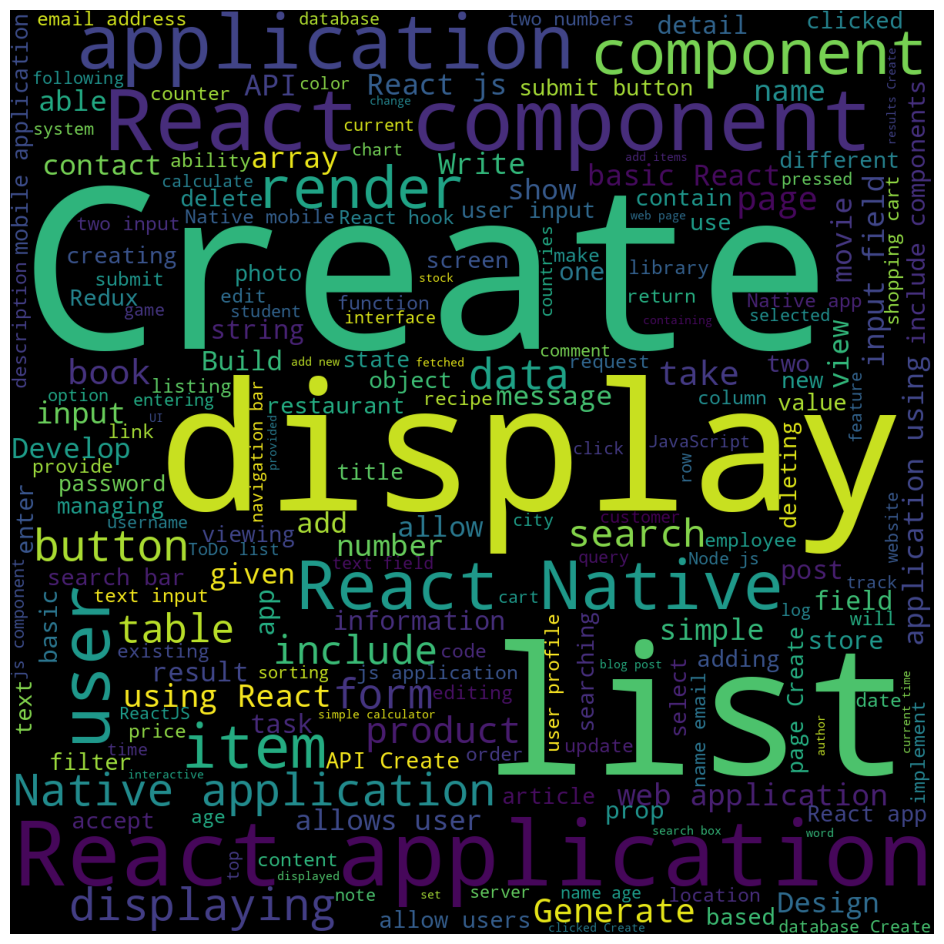

In [7]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=2023)['instruction'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS,).generate(text=text), )
axis('off')

In [8]:
# https://www.kaggle.com/code/ianalyticsgeek/keywords-extraction-using-bert
from arrow import now
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# we can't use more features than we can visualize
MAX_FEATURES = 150

NGRAM_RANGE = (1, 1)
model_start = now()

vocabulary = ['author', 'library', 'book', 'restaurant', 'menu', 'server', 'date', 'age', 'weather', 'movies', '10', 'prices', 'buttons',
             'calculator', 'javascript', 'blog', 'html', 'password', 'delete', 'string', 'email', 'username', 'website', 'shopping', 
              'database']

print(sorted(vocabulary))

# we can use our hard-won list of known keywords or we can take our chances and try to have the vectorizer find it
if len(vocabulary):
    count = TfidfVectorizer(ngram_range=(1, 1),
        vocabulary=vocabulary).fit(raw_documents=df['instruction'],)
else:
    count = TfidfVectorizer(ngram_range=NGRAM_RANGE, stop_words='english', max_features=MAX_FEATURES,
                            min_df=0.009,
                            max_df=0.05,
                           ).fit(raw_documents=df['instruction'])
features = count.get_feature_names_out()
print('{}: got {} features'.format(now().time(), len(features)))

# add a feature prevalence counter using a CountVectorizer
feature_count = CountVectorizer(vocabulary=features).fit_transform(raw_documents=df['instruction'])
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
print('{}: built model'.format(now().time()))

all_embedding = model.encode(df['instruction'].values.tolist() + features.tolist())
print('{}: got all embeddings'.format(now().time()))
embedding = all_embedding[:-len(features)]
feature_embeddings = all_embedding[-len(features):]
print('model time: {}'.format(now() - model_start))

['10', 'age', 'author', 'blog', 'book', 'buttons', 'calculator', 'database', 'date', 'delete', 'email', 'html', 'javascript', 'library', 'menu', 'movies', 'password', 'prices', 'restaurant', 'server', 'shopping', 'string', 'username', 'weather', 'website']
19:58:21.705315: got 25 features


19:58:47.602551: built model


Batches:   0%|          | 0/113 [00:00<?, ?it/s]

20:00:22.088809: got all embeddings
model time: 0:02:00.483446


In [9]:
from plotly.express import bar
from plotly.express import treemap
HEAD_N = 70

if len(features) < HEAD_N:
    bar(x='word', y='count',
    data_frame=pd.DataFrame(data={'word': features, 'count': feature_count.toarray().sum(axis=0)}).sort_values(ascending=False, by='count'),        
    ).show()
else:
    treemap(
        path=['word'], names='word', values='count', color='count', height=800,
           color_continuous_scale='bluered',
        data_frame=pd.DataFrame(data={'word': features, 'count': feature_count.toarray().sum(axis=0)}).sort_values(ascending=False, by='count').head(n=min(HEAD_N, len(features))),
    ).show()

In [10]:
# now we can project the feature vectors into 2-space to visualize 
from pandas import DataFrame
from plotly.express import scatter
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=2023, verbose=1, n_iter=10000, perplexity = min(50, len(features)-1))
tsne_df = DataFrame(data=tsne.fit_transform(X=feature_embeddings), columns=['t0', 't1'])
tsne_df['word'] = features
tsne_df['score'] = count.transform(features).toarray().sum(axis=0)
scatter(data_frame=tsne_df, x='t0', y='t1', text='word', hover_data=['score'], height=900, ).update_traces(marker={'size': 1})

[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 123.168057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.947575
[t-SNE] KL divergence after 900 iterations: 0.000021


TSNE spreads most of the values out so we can get a look at them. There are clues here that the keywords may not be evenly distributed across the corpus. Let's try using UMAP to visualize the entire document landscape (of our sample) to see how our keywords represent the corpus.

In [11]:
from pandas import DataFrame
from plotly.express import scatter
from umap import UMAP
umap_model = UMAP(n_components=3, random_state=2023, verbose=1, init='pca', n_jobs=1)
umap_df = DataFrame(data=umap_model.fit_transform(X=embedding,), columns=['u0', 'u1', 'u2'])
umap_df['instruction'] = df['instruction'].values.tolist()
umap_feature_df = DataFrame(data=umap_model.transform(X=feature_embeddings,), columns=['u0', 'u1', 'u2'])
umap_feature_df['word'] = features
umap_feature_df['score'] = count.transform(features).toarray().sum(axis=0)

UMAP(init='pca', n_components=3, n_jobs=1, random_state=2023, verbose=1)
Wed Dec  6 20:00:55 2023 Construct fuzzy simplicial set
Wed Dec  6 20:01:11 2023 Finding Nearest Neighbors
Wed Dec  6 20:01:17 2023 Finished Nearest Neighbor Search
Wed Dec  6 20:01:20 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec  6 20:01:29 2023 Finished embedding


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [12]:
from plotly.graph_objects import Figure
from plotly.graph_objects import Scatter
figure = Figure().update_layout(height=800)
figure.add_trace(Scatter(x=umap_df['u1'], y=umap_df['u2'], mode='markers', marker=dict(color=umap_df['u0'], colorscale='Peach'),
                        text=umap_df['instruction']))
figure.add_trace(Scatter(x=umap_feature_df['u1'], y=umap_feature_df['u2'], mode='text', text=umap_feature_df['word'], ))
figure.show()